In [1]:
from skimage import io
import matplotlib.pyplot as plt
from skimage import io,color,measure,morphology,feature
import skimage
import re
import matplotlib as mpl
from pandas import DataFrame
import cv2
from cellpose import utils, io, models, plot
import os
import pandas as pd
import numpy as np
from glob import glob
from natsort import natsorted


In [2]:
#change working directory
os.chdir('20231122-HBEC_Yoko_Lib5-2_G+R-_DL_N22')
cd = os.getcwd()

In [3]:
#read TRANSFORMATION MATRIX 
with open('registration/Fused_direct_transf.txt', 'r') as file:
    lines = file.readlines()
w=int(lines[0].strip().split('=')[1])
h=int(lines[1].strip().split('=')[1])
x=lines[3+1:3+h+1]
y=lines[3+h+3:]

X = [[float(j) for j in i.strip().split()] for i in x]
Y = [[float(j) for j in i.strip().split()] for i in y]
X = np.array(X)
Y = np.array(Y)

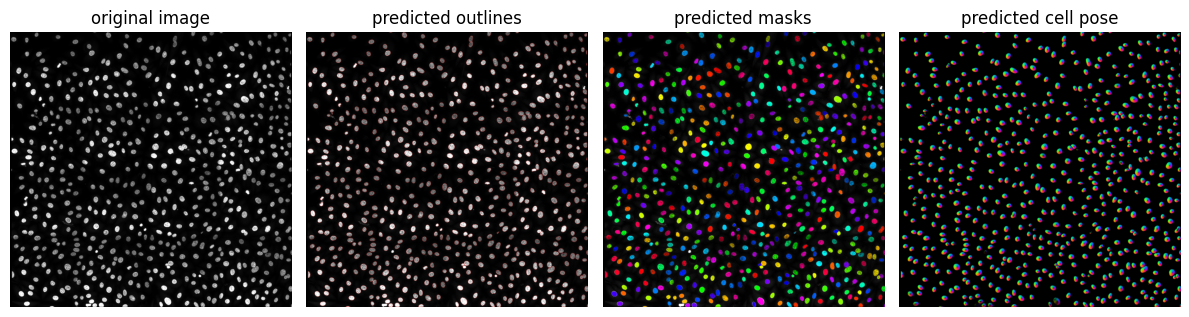

In [5]:
#segment ISS stitched image 
os.chdir(os.path.join(cd,'segmentation/'))
filename = 'Fused.tif'
img = io.imread(filename)
model = models.Cellpose(gpu=False, model_type='nuclei')
chan = [3,0]
masks, flows, styles, diams = model.eval(img, diameter=None, channels=chan)
io.masks_flows_to_seg(img, masks, flows, diams, filename, chan)
io.save_to_png(img, masks, flows, filename)
fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img, masks, flows[0], channels=chan)
plt.tight_layout()
plt.show()
props = measure.regionprops_table(masks, properties=['label','centroid','area'])
props_dataframe = DataFrame(props)
os.chdir(cd)


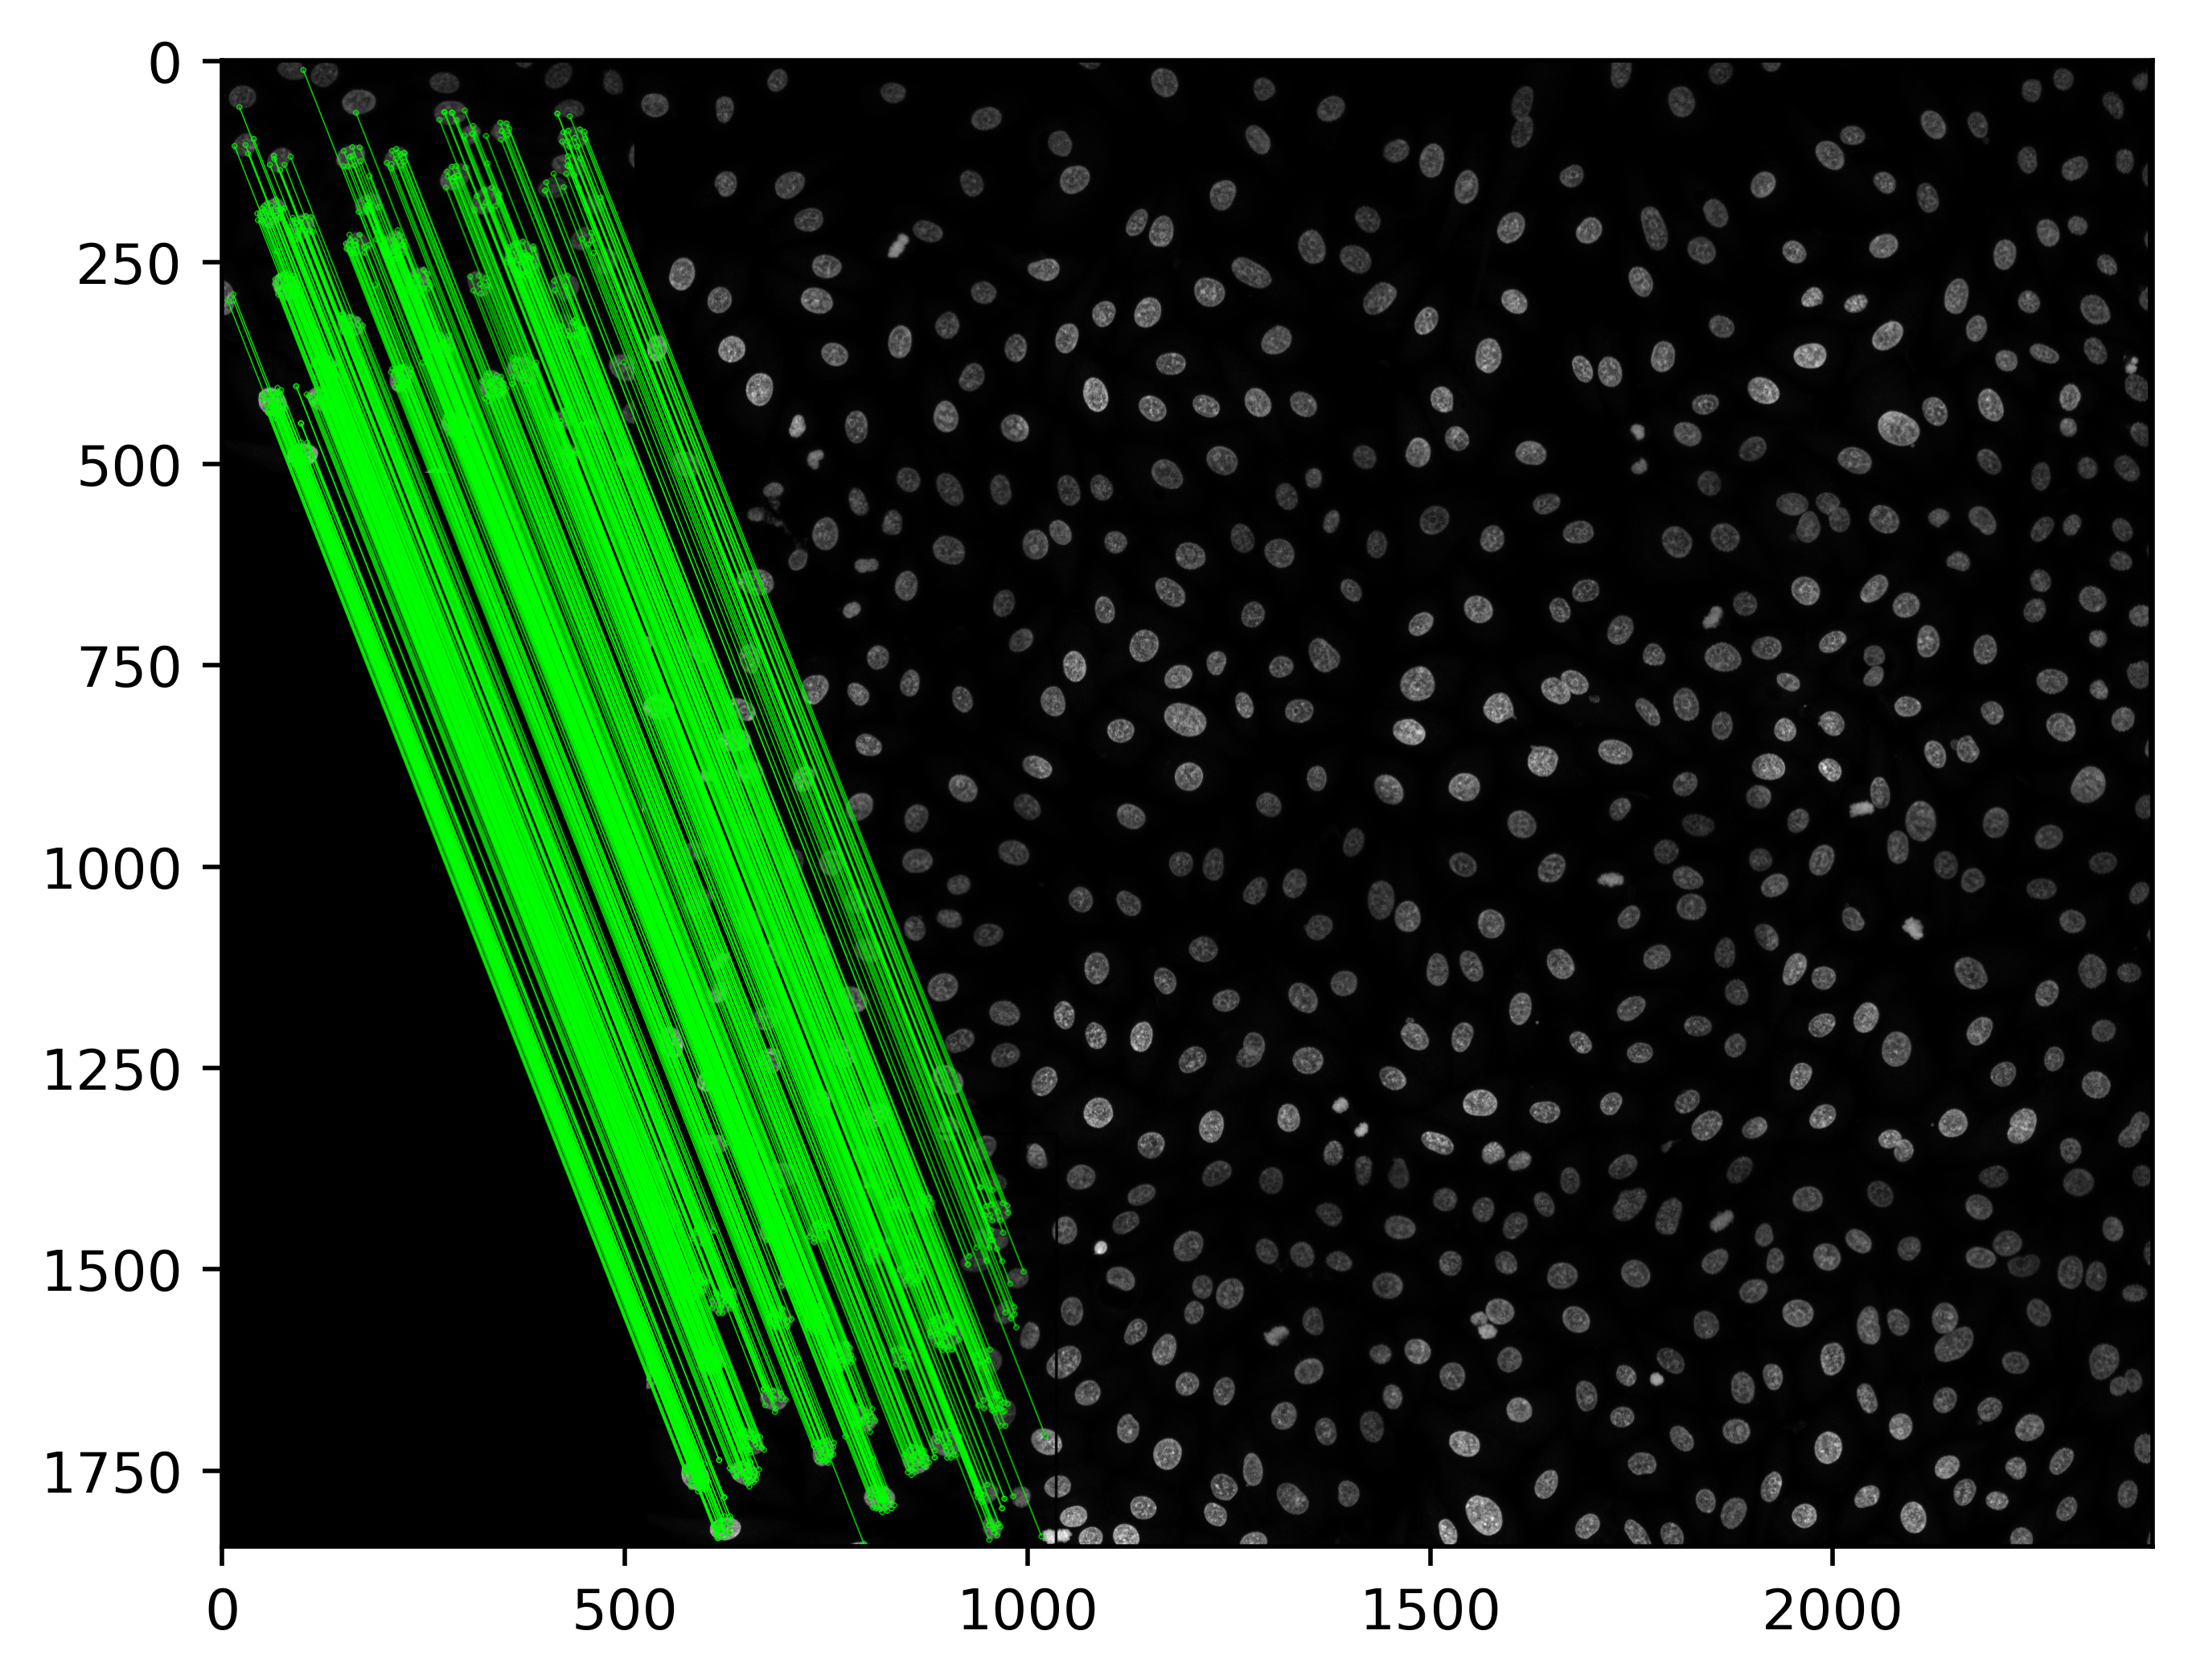

In [10]:
#Template Matching----ISS

os.chdir(os.path.join(cd,'segmentation/'))
#FLANN based Matcher
import numpy as np
import cv2
from matplotlib import pyplot as plt
 
iss_raw_stitched_seg = cv2.imread('Fused_cp_masks.png', cv2.IMREAD_ANYDEPTH | cv2.IMREAD_GRAYSCALE)
iss_raw_stitched_seg_label = skimage.measure.label(iss_raw_stitched_seg)

columns = ["time","well","tile","iss-cell","trans-iss-mask","iss-centroid0","iss-centroid1","trans-iss-centroid0","trans-iss-centroid1"]
iss_df = pd.DataFrame(columns = columns )
indexsize = iss_df.index.size 

for file in natsorted(glob('63X_1-SBS-1_*_Tile-*.sbs.tif')):
    well = re.findall("63X_1-SBS-1_(.*)_Tile",file)[0]
    tile = re.findall("_Tile-(.*).sbs.tif",file)[0]
    time = os.getcwd().split('\\')[-2].split('-')[0]

    #if tile != '15': continue
    target = cv2.imread('Fused.tif',cv2.IMREAD_ANYDEPTH | cv2.IMREAD_GRAYSCALE)  # trainImage
    template = cv2.imread(file,cv2.IMREAD_ANYDEPTH | cv2.IMREAD_GRAYSCALE) # queryImage
    template_label = cv2.imread(file.replace('.tif','_cp_masks.png'),cv2.IMREAD_ANYDEPTH | cv2.IMREAD_GRAYSCALE)
    
    # 识别分割图像a的centroid
    nuclei = template_label
    centroid = measure.regionprops_table(nuclei, properties=['label','centroid','area'])     
    centroid_df = pd.DataFrame(centroid)

    MIN_MATCH_COUNT = 10 #设置最低特征点匹配数量为10
    
    # Initiate SIFT detector
    sift = cv2.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(template,None)
    kp2, des2 = sift.detectAndCompute(target,None)
    #创建设置FLANN匹配
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 3)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    # store all the good matches as per Lowe's ratio test.
    good = []
    #舍弃大于0.7的匹配
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    if len(good)>MIN_MATCH_COUNT:
        # 获取关键点的坐标
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        #计算变换矩阵和MASK
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()
        h,w = template.shape
        # 使用得到的变换矩阵对原图像的四个角进行变换，获得在目标图像上对应的坐标
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)
        cv2.polylines(target,[np.int32(dst)],True,0,2, cv2.LINE_AA)
    
    draw_params = dict(matchColor=(0,255,0), 
                       singlePointColor=None,
                       matchesMask=matchesMask, 
                       flags=2)
    result = cv2.drawMatches(template,kp1,target,kp2,good,None,**draw_params)
    plt.figure(dpi=500)
    plt.imshow(result, 'gray')
    plt.show()
    
    for i in range(len(centroid_df)):
        centroid0 = int(centroid_df['centroid-0'][i])
        centroid1 = int(centroid_df['centroid-1'][i])
        point_to_transform = np.array([[centroid1, centroid0]], dtype=np.float32)
        transformed_point = cv2.perspectiveTransform(point_to_transform.reshape(-1, 1, 2), M)
        centroid0_trans = int(transformed_point[0][0][1])
        centroid1_trans = int(transformed_point[0][0][0])
        item = time, well, tile, nuclei[centroid0][centroid1], iss_raw_stitched_seg_label[centroid0_trans][centroid1_trans],centroid0,centroid1,centroid0_trans,centroid1_trans
        iss_df.loc[indexsize] = item
        indexsize = indexsize + 1 

#iss_df = iss_df[iss_df['trans-iss-mask']!=0]
iss_df.to_excel(cd+'\\registration\\iss-regi.xlsx',index=None)
os.chdir(cd)

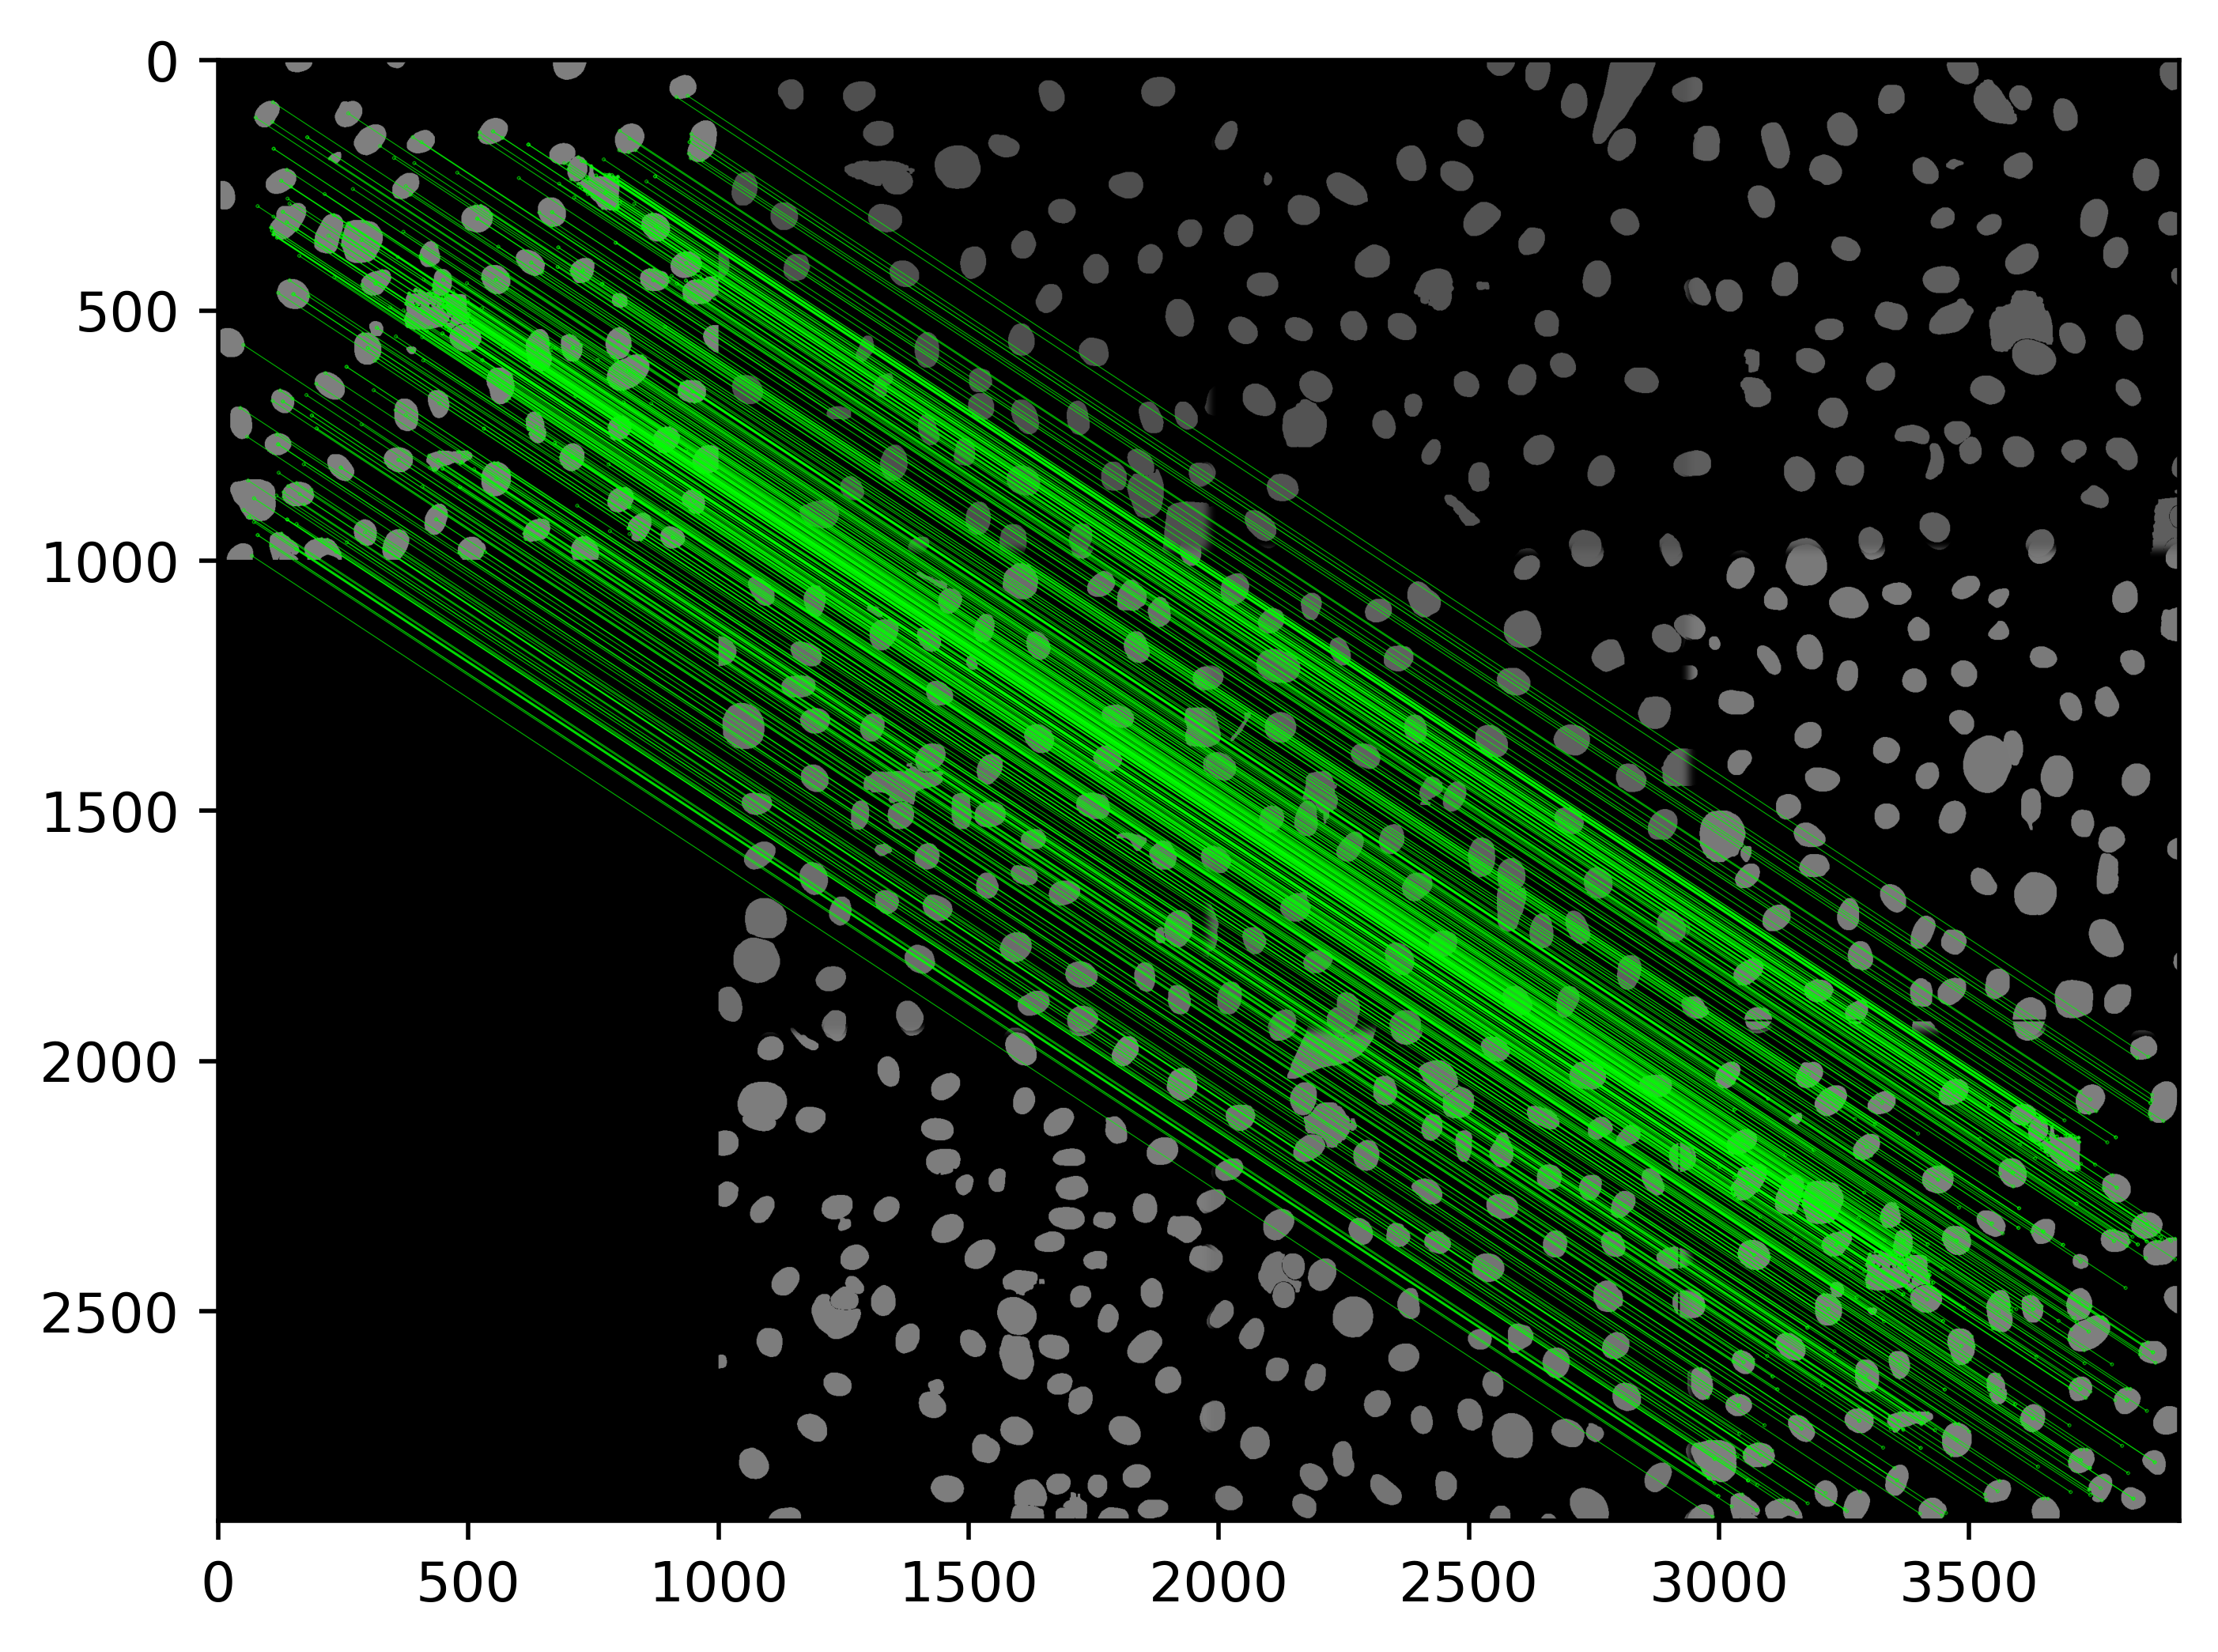

In [14]:
#Template Matching----ISS


os.chdir(os.path.join(cd,'live-seg/'))

columns = ["time","field","live-cell","trans-iss-mask","live-centroid0","live-centroid1","trans-live-centroid0","trans-live-centroid1","new-iss-centroid0","new-iss-centroid1"]
live_df = pd.DataFrame(columns = columns )
indexsize = live_df.index.size 

for file,field in zip(natsorted(glob('f[0-9]*.tif')),range(1,len(natsorted(glob('f[0-9]*.tif')))+1)):
    well =  os.getcwd().split('\\')[-2].split('_')[-1]
    time = os.getcwd().split('\\')[-2].split('-')[0]

    #if field != 9: continue

    target = cv2.imread('Fused.tif',0)  # trainImage
    template = cv2.imread(file,0) # queryImage
    template_label = cv2.imread(file,cv2.IMREAD_ANYDEPTH | cv2.IMREAD_GRAYSCALE) # queryImage

    # 识别分割图像a的centroid
    nuclei = template_label
    centroid = measure.regionprops_table(nuclei, properties=['label','centroid','area'])     
    centroid_df = pd.DataFrame(centroid)

    MIN_MATCH_COUNT = 40 #设置最低特征点匹配数量为10
    # Initiate SIFT detector创建sift检测器

    sift = cv2.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(template,None)
    kp2, des2 = sift.detectAndCompute(target,None)
    #创建设置FLANN匹配
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 3)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    # store all the good matches as per Lowe's ratio test.
    good = []
    #舍弃大于0.7的匹配
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    if len(good)>MIN_MATCH_COUNT:
        # 获取关键点的坐标
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        #计算变换矩阵和MASK
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()
        h,w = template.shape
        # 使用得到的变换矩阵对原图像的四个角进行变换，获得在目标图像上对应的坐标
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)
        cv2.polylines(target,[np.int32(dst)],True,0,2, cv2.LINE_AA)
    
    draw_params = dict(matchColor=(0,255,0), singlePointColor=None,matchesMask=matchesMask, flags=2)
    result = cv2.drawMatches(template,kp1,target,kp2,good,None,**draw_params)
    plt.figure(dpi=500)
    plt.imshow(result, 'gray')
    plt.show()
    
    
    for i in range(len(centroid_df)):
        centroid0 = int(centroid_df['centroid-0'][i])
        centroid1 = int(centroid_df['centroid-1'][i])
        point_to_transform = np.array([[centroid1, centroid0]], dtype=np.float32)
        transformed_point = cv2.perspectiveTransform(point_to_transform.reshape(-1, 1, 2), M)
        centroid0_trans = int(transformed_point[0][0][1])
        centroid1_trans = int(transformed_point[0][0][0])
        
        new_centroid1 = int(X[centroid0_trans, centroid1_trans])
        new_centroid0 = int(Y[centroid0_trans, centroid1_trans])

        #if new_centroid0 > 1867 or new_centroid1 >1876: continue

        item = time, field, nuclei[centroid0][centroid1], iss_raw_stitched_seg_label[new_centroid0][new_centroid1],centroid0,centroid1,centroid0_trans,centroid1_trans,new_centroid0,new_centroid1
        live_df.loc[indexsize] = item
        indexsize = indexsize + 1 
live_df.to_excel(cd+'\\registration\\live-regi.xlsx',index=None)
os.chdir(cd)

In [ ]:
#generate result table
os.chdir(os.path.join(cd,'registration/'))
live_df=pd.read_excel('live-regi.xlsx')
iss_df=pd.read_excel('iss-regi.xlsx')
live_iss = pd.merge(iss_df,live_df,on='trans-iss-mask') 
live_iss = live_iss[live_iss['trans-iss-mask']!=0]
live_iss.to_excel('iss-regi-live.xlsx',index=None)
os.chdir(cd)